# Global CO₂ Emissions Analysis
## Notebook 4: Future Emission Scenarios (2025-2100)

Project global CO₂ emissions under alternative scenarios to investigate the importance of per capita convergence and decarbonization pathways.

**Key questions:**
- What if countries maintain current per-capita emissions?
- What if all countries converge to EU levels?
- What if we achieve net zero by 2050?
- How do population projections affect total emissions?

## Scenarios Defined:

### **Scenario A - frozen per capita**:
Each country maintains its 2024 per-capita emission level, population grows according to UN projections.
The purpose is to show what happens with no decarbonization effort.

### **Scenario B - EU convergence**
All countries converge to current EU average with an instant convergence assumed (for simplicity).
The purpose is to show the impact of global adoption of EU-level efficiency.

### **Scenario C - World average convergence**
All countries converge to current global average with an instant convergence assumed (for simplicity).
The purpose is to show an "equity" scenario (equal per-capita emissions).

### **Scenario D: Net Zero by 2050**
Linear reduction from 2024 levels to zero by 2050 ans zero emissions maintained after 2050
The purpose is to show Paris Agreement-aligned pathway and its difference with the previous scenarios.



## Important Disclaimer

These are **exploratory "what-if" scenarios**, NOT predictions or forecasts.
Real-world emissions depend on policy, technology, economics, and countless other factors not modeled here.
Scenarios A, B, and C are **not realistic policy scenarios**. They serve a different purpose:
#### **Scenario A (Frozen Per-Capita): "What if we do nothing?"**
- Assumes every country maintains its 2024 per capita emissions forever
- Only population changes affect total emissions
- Shows the "business as usual" baseline that would lead to ~2.5-3°C warming (catastrophic).
#### **Scenario B (EU Convergence): "What if lifestyle convergence happens?"**
- Assumes everyone adopts European living standards (6.3 t/person)
- Ignores the fact that Europe needs to decarbonize
- Shows that even "developed country" emissions are too high, it would lead to 3°C+ warming (even worse than doing nothing).
#### **Scenario C (World Average): "What if everyone becomes average?"**
- Assumes perfect equality at today's global average (4.7 t/person)
- Shows that even the current global average is unsustainable and would lead to ~2.7°C warming (still far above Paris goals).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df1 =  pd.read_csv("/content/annual-co2-emissions-per-country.csv")
df2 = pd.read_csv("/content/co-emissions-per-capita.csv")
df3 = pd.read_csv("/content/co2-by-source.csv")
df4 = pd.read_csv("/content/population.csv")
df4.columns = ["Entity","Code","Year","Population"]
df = df1.merge(df2,on=["Entity","Code","Year"],how="outer").merge(df3,on=["Entity","Code","Year"],how="outer").merge(df4,on=["Entity","Code","Year"],how="outer")
df_country = df.dropna(subset="Code")
df_country = df_country[~(df_country["Entity"]=="World")]

df_pop_future = df_country[df_country["Year"]>2024]   # we filter to ger the projection period
df_reference = df_country[df_country["Year"]==2024]   # we need to define the baseline for scenarios.
df_reference  = df_reference[["Entity","Code","Annual CO₂ emissions (per capita)"]]
df_reference.columns = ["Entity", "Code", "co2_pc_2024"]
df_pop_future = df_pop_future[["Entity","Code","Year","Population"]]

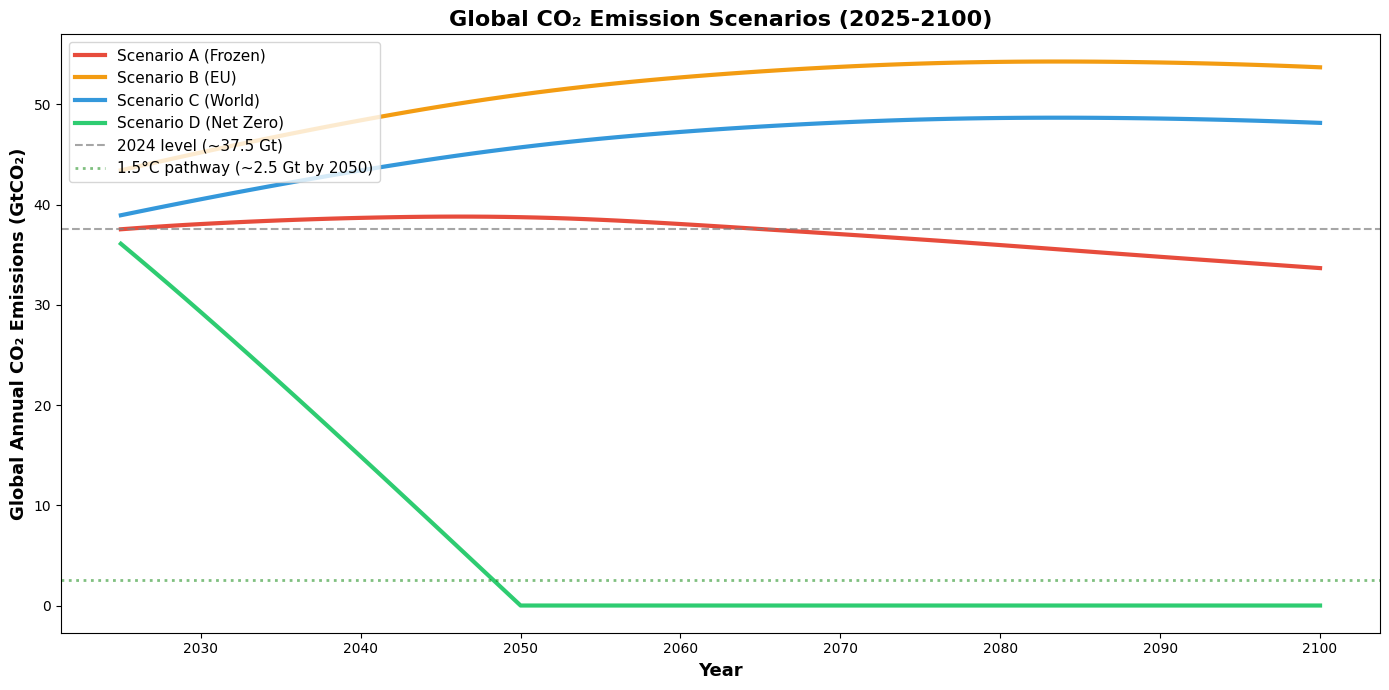

In [ ]:
# Scenario A - every country keep its co2_pc for each year in the future

scenario_a = df_pop_future.merge(df_reference, on=["Entity","Code"])
scenario_a["co2_future_A"] = scenario_a["Population"] * scenario_a["co2_pc_2024"]

#scenario B - EU convergence

df_eu = df[df["Entity"]=="European Union (28)"]
df_eu = df_eu[df_eu["Year"] ==2024]
co2_pc_2024_eu = df_eu["Annual CO₂ emissions (per capita)"].iloc[0]
scenario_b = df_pop_future.copy()
scenario_b["co2_future_B"] = scenario_b["Population"]* co2_pc_2024_eu

#scenario C - world convergence

df_world = df[df["Entity"] == "World"]
df_world = df_world[df_world["Year"] == 2024]
co2_pc_2024_world = df_world["Annual CO₂ emissions (per capita)"].iloc[0]
scenario_c = df_pop_future.copy()
scenario_c["co2_future_C"] = scenario_c["Population"]* co2_pc_2024_world

#scenario D - linear reduction of emission alligned with the net zero 2050.

scenario_d = df_pop_future.merge(df_reference, on=["Entity","Code"], how="inner")

conditions = [
    scenario_d["Year"] <= 2024,
    (scenario_d["Year"] > 2024) & (scenario_d["Year"] <= 2050),
    scenario_d["Year"] > 2050
]

choices = [
    scenario_d["co2_pc_2024"],
    scenario_d["co2_pc_2024"] * (1 - (scenario_d["Year"] - 2024) / 26),
    0
]

scenario_d["co2_pc_D"] = np.select(conditions, choices, default=0)
scenario_d["co2_future_D"] = scenario_d["co2_pc_D"] * scenario_d["Population"]


# let's merge all four scenarios into a single dataframe for comparison

df_scenarios = scenario_a[["Entity","Code","Year","Population","co2_future_A"]].merge(
    scenario_b[["Entity","Code","Year","co2_future_B"]],
    on=["Entity","Code","Year"],
    how="outer"
).merge(
    scenario_c[["Entity","Code","Year","co2_future_C"]],
    on=["Entity","Code","Year"],
    how="outer"
).merge(
    scenario_d[["Entity","Code","Year","co2_future_D"]],
    on=["Entity","Code","Year"],
    how="outer"
)

#aggregate to global level for each year

df_global = df_scenarios.groupby("Year")[["co2_future_A","co2_future_B","co2_future_C","co2_future_D"]].sum().reset_index()


#convert to GtCO₂ for readability
df_global["Scenario A (Frozen)"] = df_global["co2_future_A"] / 1e9
df_global["Scenario B (EU)"] = df_global["co2_future_B"] / 1e9
df_global["Scenario C (World)"] = df_global["co2_future_C"] / 1e9
df_global["Scenario D (Net Zero)"] = df_global["co2_future_D"] / 1e9


df_plot = df_global[["Year","Scenario A (Frozen)","Scenario B (EU)","Scenario C (World)","Scenario D (Net Zero)"]].melt(
    id_vars="Year",
    var_name="Scenario",
    value_name="Global_CO2_GtCO2"
)

df_plot = df_global[["Year","Scenario A (Frozen)","Scenario B (EU)","Scenario C (World)","Scenario D (Net Zero)"]].melt(
    id_vars="Year",
    var_name="Scenario",
    value_name="Global_CO2_GtCO2"
)


plt.figure(figsize=(14,7))
colors = {
    "Scenario A (Frozen)": "#e74c3c",
    "Scenario B (EU)": "#f39c12",
    "Scenario C (World)": "#3498db",
    "Scenario D (Net Zero)": "#2ecc71"
}
sns.lineplot(
    data=df_plot,
    x="Year",
    y="Global_CO2_GtCO2",
    hue="Scenario",
    palette=colors,
    linewidth=3
)

plt.axhline(y=current_2024, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label=f"2024 level (~{current_2024:.1f} Gt)")
plt.axhline(y=2.5, color='green', linestyle=':', linewidth=2, alpha=0.5, label="1.5°C pathway (~2.5 Gt by 2050)")
plt.xlabel("Year", fontsize=13, fontweight='bold')
plt.ylabel("Global Annual CO₂ Emissions (GtCO₂)", fontsize=13, fontweight='bold')
plt.title("Global CO₂ Emission Scenarios (2025-2100)", fontsize=16, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
years_of_interest = [2030, 2040, 2050, 2075, 2100]

comparison = df_global[df_global["Year"].isin(years_of_interest)][
    ["Year","Scenario A (Frozen)","Scenario B (EU)","Scenario C (World)","Scenario D (Net Zero)"]
]

print("Global emissions by scenario (GtCO₂):")
print(comparison)

Global emissions by scenario (GtCO₂):
    Year  Scenario A (Frozen)  Scenario B (EU)  Scenario C (World)  \
5   2030            38.050515        45.189741           40.524040   
15  2040            38.667825        48.396405           43.399627   
25  2050            38.735873        50.965618           45.703576   
50  2075            36.514794        54.056541           48.475371   
75  2100            33.656453        53.685622           48.142748   

    Scenario D (Net Zero)  
5               29.269627  
15              14.872240  
25               0.000000  
50               0.000000  
75               0.000000  


Key Findings:

### 1. The Only Viable Path: Scenario D
Looking at the scenario plot, it is immediately clear that there is a massive gap between where scenarios A, B, C and where we need to be (Scenario D).

**The chart shows that:**
- Maintaining current per capita levels → 2.7°C warming
- Adopting "rich country" lifestyles globally → 3°C+ warming
- Even global equality at today's average → 2.7°C warming
- Only rapid decline to zero → 1.5-2°C (Paris goals)

Scenario D is the only one aligned with climate science.

**What it requires in practical terms:**
- Close/convert virtually all coal plants by 2035-2040
- Electrify 80%+ of transport by 2050
- Decarbonize industry (steel, cement, chemicals)
- Deploy massive renewable energy + storage
- Transform agriculture and land use

**What Would It Take to Follow Scenario D?**

| Period | Required Action | Real-World Example |
|--------|----------------|-------------------|
| **2025-2030** | -4% per year | COVID dropped emissions 7% (one year only) |
| **2030-2040** | -6% per year | 2008 crisis: -1.4% (one year only) |
| **2040-2050** | -10%+ per year | Unprecedented in modern history |

By 2030:
- Solar + wind = 50%+ of global electricity (currently ~12%)
- EVs = 50%+ of new car sales (currently ~18%)
- Phase out 30% of coal plants (retire ~600 GW)
- Halt deforestation, begin large-scale reforestation

By 2040:
- Renewables = 80%+ of electricity
- 90%+ of new vehicles are electric
- No new fossil fuel infrastructure
- Green steel and cement commercially viable
- Sustainable aviation fuels at scale

By 2050:
- 100% clean electricity globally
- 80%+ of vehicle fleet electric
- All heavy industry decarbonized or carbon-captured
- Net-zero emissions across all sectors
- Nature-based solutions absorbing residual emissions

